In [217]:
from typing import Dict, Callable, Any, List, Tuple
from functools import partial
from dataclasses import dataclass
from collections import defaultdict
from pathlib import Path
import json
import pandas as pd
import os
import wandb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle

from zeus.data.converter import get_converter

In [ ]:
EARLIEST_START = pd.Timestamp("2025-10-11")
LATEST_START = pd.Timestamp("2025-10-30")

In [3]:
api = wandb.Api(timeout=30)
runs = []
for run in api.runs("orpheus-ai/zeus-subnet"):
    created = pd.Timestamp(run.createdAt).tz_convert(None)
    if created > EARLIEST_START and created < LATEST_START:
        runs.append(run)

print(f"Fetched {len(runs)} runs")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Fetched 1319 runs


In [22]:
@dataclass
class Challenge:
    window: int
    variable: str
    ifs_rmse: float
    avg_miner_rmse: float

    rmse_per_hotkey: Dict[str, float]

challenges = []
for run in tqdm(runs):
    for row in run.scan_history():

        ifs_rmse = row.get("ifs_hres_rmse")
        # if too old or not correctly calculated, ignore this sample
        if ifs_rmse in [None, -1, "NaN"]:
            continue

        rmses = []
        rmse_per_hotkey = {}
        for k, v in row.items():
            if k.startswith("miner_") and "RMSE" in k and v not in [None, -1]:
                rmses.append(v)

                # find coldkey and aggregate if applicablr
                uid = int(k.split("_")[-2])
                hotkey = row[f"uid_to_hotkey.{uid}"]

                rmse_per_hotkey[hotkey] = v

        if not rmses:
            continue

        mid_timestamp = (row["start_timestamp"] + row["end_timestamp"]) / 2
        window = (mid_timestamp - row["query_timestamp"]) // pd.Timedelta(days=1).total_seconds()

        challenges.append(Challenge(
            window=window,
            variable=row["variable"], 
            ifs_rmse=ifs_rmse,
            avg_miner_rmse=np.mean(rmses),
            rmse_per_hotkey=rmse_per_hotkey,
        ))

100%|██████████| 1319/1319 [14:11<00:00,  1.55it/s]


In [23]:
print(f"We have {len(challenges)} challenges!")

We have 81460 challenges!


In [30]:
np.unique([c.window for c in challenges])

array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.])

In [27]:
for window in np.unique([c.window for c in challenges]):
    window_subset = [c for c in challenges if c.window == window]
    print(f"Window={window}    NUM_CHALLENGES={len(window_subset)}")

Window=-5.0    NUM_CHALLENGES=30853
Window=-4.0    NUM_CHALLENGES=28649
Window=-3.0    NUM_CHALLENGES=12873
Window=-2.0    NUM_CHALLENGES=3977
Window=-1.0    NUM_CHALLENGES=1246
Window=0.0    NUM_CHALLENGES=648
Window=1.0    NUM_CHALLENGES=604
Window=2.0    NUM_CHALLENGES=575
Window=3.0    NUM_CHALLENGES=544
Window=4.0    NUM_CHALLENGES=510
Window=5.0    NUM_CHALLENGES=463
Window=6.0    NUM_CHALLENGES=429
Window=7.0    NUM_CHALLENGES=89


In [ ]:
def get_best_miner(challenges: List[Challenge], aggregate_fn: Callable = np.mean, min_factor=0.3) -> Tuple[str, float, float, int]:
    scores_per_hotkey = defaultdict(list)
    for c in challenges:
        for hot, rmse in c.rmse_per_hotkey.items():
            scores_per_hotkey[hot].append(rmse)

    agg_per_hotkey = {k: aggregate_fn(v) for k,v in scores_per_hotkey.items() if len(v) > min_factor * len(challenges)} 
    best_miner = min(agg_per_hotkey, key=agg_per_hotkey.get)
    return scores_per_hotkey[best_miner]

def style_plot(barwidth, margin, windows):
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.ylim(bottom=0)
    plt.xlim(min(windows) - barwidth / 2, max(windows) + 2.5 * barwidth + 2 * margin)
    plt.gca().tick_params(axis=u'both', which=u'both',length=0, labelsize=12)

Sample sizes per window: {'0-1 Days': 133, '1-2 Days': 143, '2-3 Days': 111, '3-4 Days': 81, '4-5 Days': 108, '5-6 Days': 74, '6-7 Days': 79}


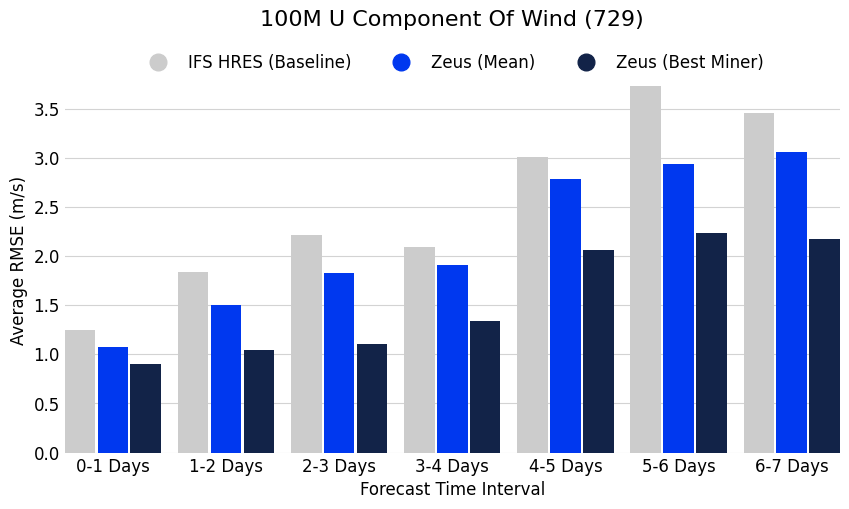

Sample sizes per window: {'0-1 Days': 118, '1-2 Days': 108, '2-3 Days': 119, '3-4 Days': 90, '4-5 Days': 92, '5-6 Days': 68, '6-7 Days': 73}


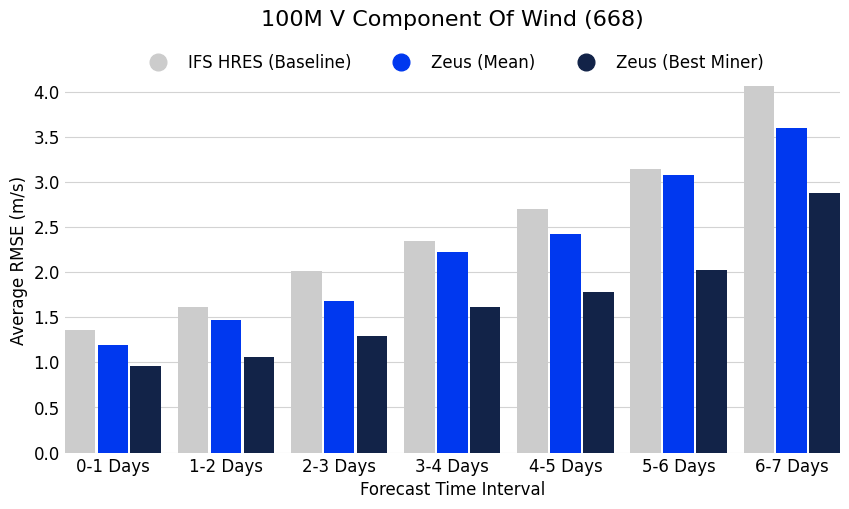

Sample sizes per window: {'0-1 Days': 138, '1-2 Days': 109, '2-3 Days': 120, '3-4 Days': 126, '4-5 Days': 108, '5-6 Days': 116, '6-7 Days': 88}


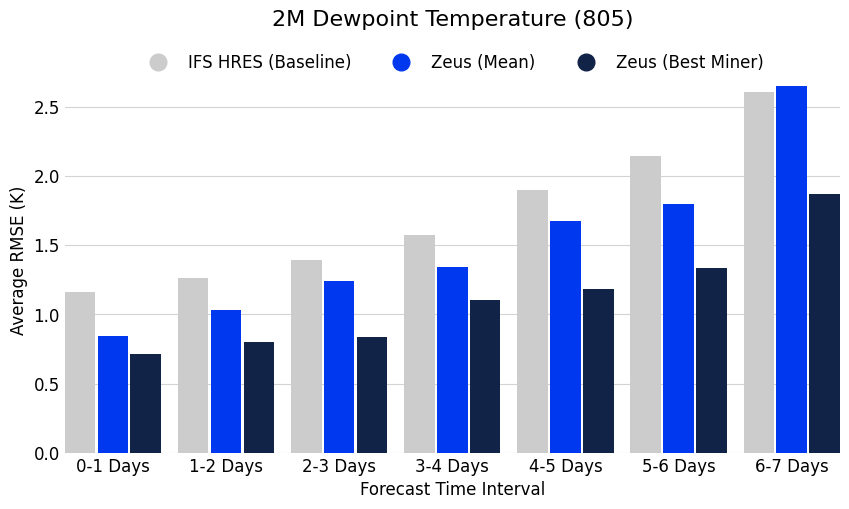

Sample sizes per window: {'0-1 Days': 115, '1-2 Days': 101, '2-3 Days': 97, '3-4 Days': 103, '4-5 Days': 82, '5-6 Days': 92, '6-7 Days': 90}


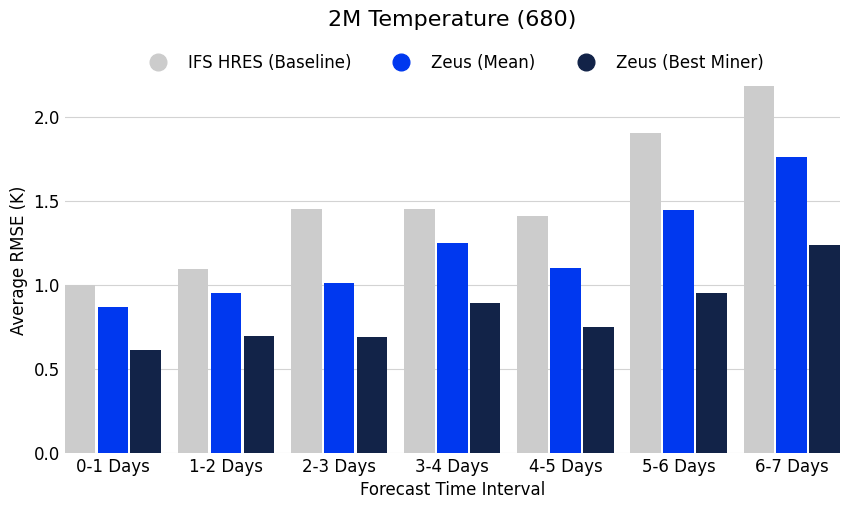

Sample sizes per window: {'0-1 Days': 29, '1-2 Days': 33, '2-3 Days': 27, '3-4 Days': 27, '4-5 Days': 25, '5-6 Days': 15, '6-7 Days': 15}


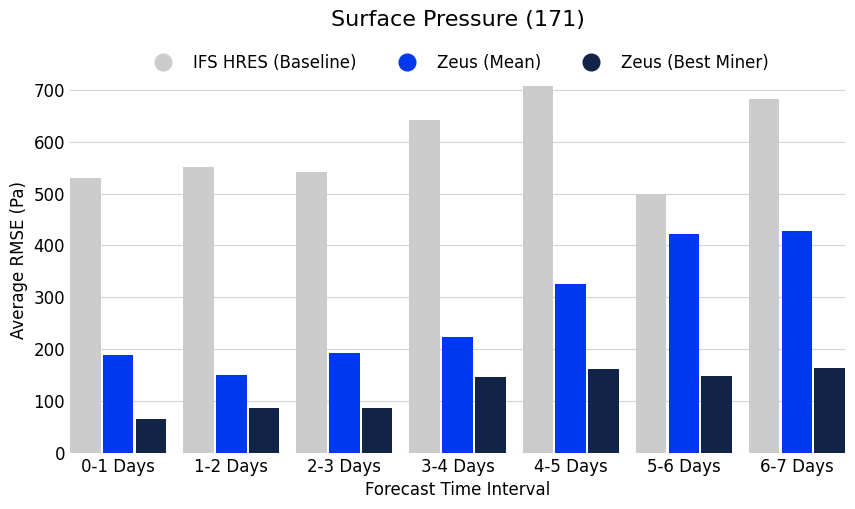

Sample sizes per window: {'0-1 Days': 115, '1-2 Days': 110, '2-3 Days': 101, '3-4 Days': 117, '4-5 Days': 95, '5-6 Days': 98, '6-7 Days': 84}


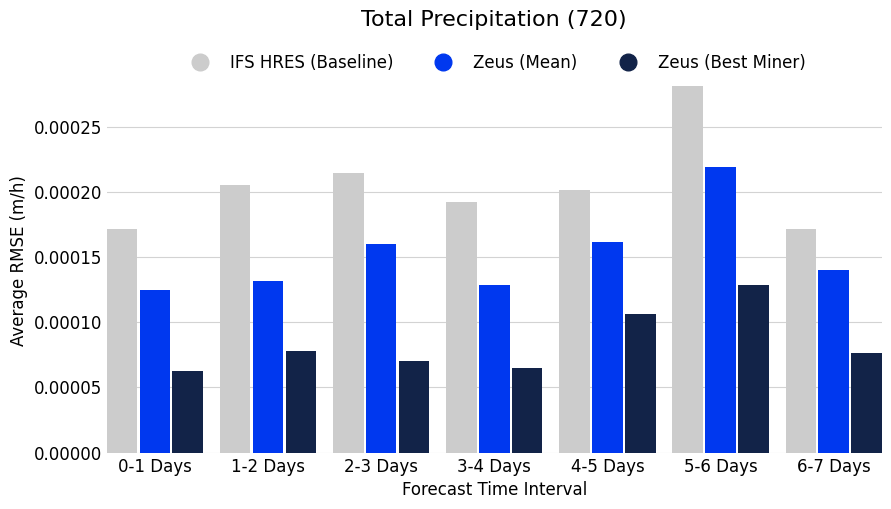

In [237]:
variables = np.unique([c.variable for c in challenges])
colors = ['#cccccc', '#0038ef', '#122348']
barwidth = 0.27
margin = 0.02

for i, variable in enumerate(variables):
    plt.figure(figsize=(10, 5), dpi=100)
    plt.grid(axis="y", zorder=0, color="lightgray")
    subset: List[Challenge]  = [c for c in challenges if c.variable == variable]

    windows = np.unique([c.window for c in subset]).astype(int)[:-1] # Exclude longest window due to low sample count
    windows = np.array([0, 1, 2, 3, 4, 5, 6])
    for j, (get_func, label) in enumerate([
        (lambda cs: [c.ifs_rmse for c in cs], "IFS HRES (Baseline)"),
        (lambda cs: [c.avg_miner_rmse for c in cs], "Zeus (Mean)"),
        (partial(get_best_miner, aggregate_fn=np.mean), "Zeus (Best Miner)"),
    ]):
        average_scores = []
        sample_sizes = []
        for window in windows:
            window_subset = [c for c in subset if c.window == window]
            scores = get_func(window_subset)

            average_scores.append(np.mean(scores))
            sample_sizes.append(len(window_subset))

        plt.plot([], [], marker="o", linestyle='None', markersize=12, color=colors[j], label=label)  # For legend only
        plt.bar(windows + j * (barwidth + margin), average_scores, width=barwidth, color=colors[j], zorder=3, )

    style_plot(barwidth, margin, windows)
    print("Sample sizes per window:", dict(zip([f"{w}-{w+1} Days" for w in windows], sample_sizes)))
    plt.xticks(windows + barwidth + margin, [f"{w}-{w+1} Days" for w in windows])
    plt.title(f"{variable.replace('_', ' ').title()} ({sum(sample_sizes)})", pad=30, fontsize=16)
    plt.xlabel("Forecast Time Interval", fontsize=12)
    plt.ylabel(f"Average RMSE ({get_converter(variable).unit})", fontsize=12)
    plt.legend(bbox_to_anchor=(0.5, 0.95), loc='lower center', ncols=3, frameon=False, fontsize=12)
    plt.savefig(f"../outputs/{variable}.pdf")
    plt.show()